# Personality ~ text: a MBTI dataset
Little toy example of how to predict personality types from text produced using transformer encodings of the text. <br>
We will use a funny dataset from Kaggle, available here: https://www.kaggle.com/datasnaek/mbti-type, trying to predict Myers-Briggs personality types from text produced by individuals on the social network "Personality Café".
It includes data from around ~8000 individuals. For each individual the dataset has the last 50 posts on PersonalityCafe and the four letters MBTI code. <br>
This latter includes a binary code for:
- introversion/extraversion
- intuition/sensing
- thinking/feeling 
- judging/perceiving

In this notebook, we will first encode all posts using BERT (pretrained), average encodings by participants, then use encodings (768-dimensional) to predict personality types for each individual (we will predict each trait separately, rather than the type).

In [2]:
import pandas as pd
import numpy as np 
import seaborn as sns
from matplotlib import pyplot as plt
from transformers  import BertTokenizer, BertModel
import torch
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_validate

## Read in and process data

In [2]:
df = pd.read_csv('mbti_data/mbti_data.csv')
df['posts'] = df['posts'].str.strip('\'')

In [3]:
df.head()

,type,posts
0,INFJ,http://www.youtube.com/watch?v=qsXHcwe3krw|||h...
1,ENTP,I'm finding the lack of me in these posts very...
2,INTP,Good one _____ https://www.youtube.com/watc...
3,INTJ,"Dear INTP, I enjoyed our conversation the ot..."
4,ENTJ,You're fired.|||That's another silly misconcep...


Split type into four scores, and rename

In [4]:
df[['intro-extro', 'intuition-sense', 'think-feel', 'judge-perceive']] = df['type'].apply(lambda x: pd.Series(list(x)))
df = df.iloc[:,1:]

In [5]:
for out in ['intro-extro', 'intuition-sense', 'think-feel', 'judge-perceive']:
    df[out] = df[out].map({df[out].unique()[0]:0, df[out].unique()[1]:1})

## Encoding text
We'll encode each post using BERT pretrained, then average the resulting [CLS] encodings across posts by individuals, which yields one 768-dimensional encoding per participant.

In [6]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

Here the actual encoding happens: it is painfully time-consuming, so just load the encodings from the next chunk. 

In [26]:
X = np.empty((df.shape[0], 768)) # features for model
for idx, r in df.iterrows():
    print(f'Row {idx} out of {df.shape[0]}')
    txt = r['posts'].split('|||')
    cls_emb_mat = np.empty((len(txt), 768))
    for n, t in enumerate(txt):
        inputs = tokenizer(t, return_tensors="pt")
        outputs = model(**inputs)
        cls_emb_mat[n, :] = outputs[0].detach().squeeze()[0]
    X[idx, :] = cls_emb_mat.mean(axis=0)
    if idx % 200 == 0:
        pd.DataFrame(X).to_csv('mbti_data/mbti_encodings.txt', sep='\t')


of 8675
Row 7723 out of 8675
Row 7724 out of 8675
Row 7725 out of 8675
Row 7726 out of 8675
Row 7727 out of 8675
Row 7728 out of 8675
Row 7729 out of 8675
Row 7730 out of 8675
Row 7731 out of 8675
Row 7732 out of 8675
Row 7733 out of 8675
Row 7734 out of 8675
Row 7735 out of 8675
Row 7736 out of 8675
Row 7737 out of 8675
Row 7738 out of 8675
Row 7739 out of 8675
Row 7740 out of 8675
Row 7741 out of 8675
Row 7742 out of 8675
Row 7743 out of 8675
Row 7744 out of 8675
Row 7745 out of 8675
Row 7746 out of 8675
Row 7747 out of 8675
Row 7748 out of 8675
Row 7749 out of 8675
Row 7750 out of 8675
Row 7751 out of 8675
Row 7752 out of 8675
Row 7753 out of 8675
Row 7754 out of 8675
Row 7755 out of 8675
Row 7756 out of 8675
Row 7757 out of 8675
Row 7758 out of 8675
Row 7759 out of 8675
Row 7760 out of 8675
Row 7761 out of 8675
Row 7762 out of 8675
Row 7763 out of 8675
Row 7764 out of 8675
Row 7765 out of 8675
Row 7766 out of 8675
Row 7767 out of 8675
Row 7768 out of 8675
Row 7769 out of 8675
Row 7

In [7]:
#X_a = X.iloc[:4000, :]
#X_b = X.iloc[4000:, :]
#pd.DataFrame(X_a).to_csv('mbti_data/mbti_encodings1.txt', sep='\t')
#pd.DataFrame(X_b).to_csv('mbti_data/mbti_encodings2.txt', sep='\t')

In [19]:
X_a = pd.read_csv('mbti_data/mbti_encodings1.txt', sep='\t').iloc[:,1:].values
X_b = pd.read_csv('mbti_data/mbti_encodings2.txt', sep='\t').iloc[:,1:].values

In [20]:
X = np.vstack((X_a, X_b))

## Fit models
Fit 10-fold CV logistic regression for each of the MBTI features separately. We also vary the number of BERT features included, to visualize how performance changes as a function of model complexity.

Set up CV parameters.

In [8]:
K = 10
est_log = LogisticRegression()
gkfolds = KFold(n_splits=K)

Fit and store performance.
Also visualize performance for each of the four features, as a function of sample size. <br>
Performance is measures as percent accurate classifications. 

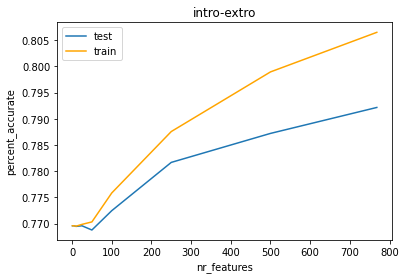

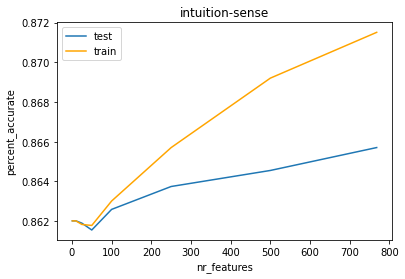

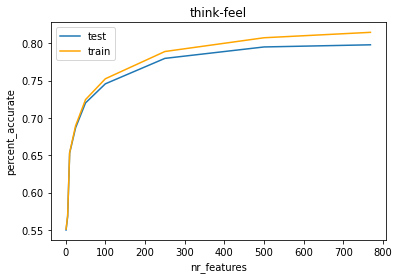

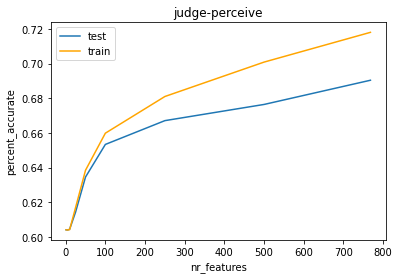

In [9]:
feats = [1, 5, 10, 25, 50, 100, 250, 500, 768]
outs = ['intro-extro', 'intuition-sense', 'think-feel', 'judge-perceive']

for o in outs:
    cv_mean_acc, cv_mean_acc_train = [], []
    for f in feats:
        np.random.seed(0)
        ridx = np.random.randint(0, X.shape[1], f)

        # get data in shape
        X_subs = X[:,ridx]
        y_subs = df[o].values
        cv_scores = cross_validate(est_log, X_subs, y_subs, 
                                cv=gkfolds, return_train_score=True)
        # Append scores
        mean_acc = cv_scores['test_score'].mean()
        mean_acc_train = cv_scores['train_score'].mean()
        cv_mean_acc.append(mean_acc)
        cv_mean_acc_train.append(mean_acc_train)
    # Show performance
    sns.lineplot(feats, cv_mean_acc, label='test')
    sns.lineplot(feats, cv_mean_acc_train, label='train', color='orange')
    plt.xlabel('nr_features')
    plt.ylabel('percent_accurate')
    plt.title(o)
    plt.show()

## Sample size and performance
Here we visualize how performance changes as a function of the number of samples included (for each outcome variable). <br>
All 768 dimensions are included as predictors in the model.

In [10]:
sizes = [50, 100, 500, 1000, 5000, X.shape[0]]

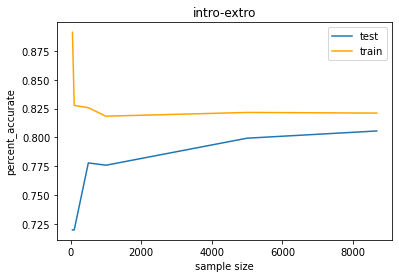

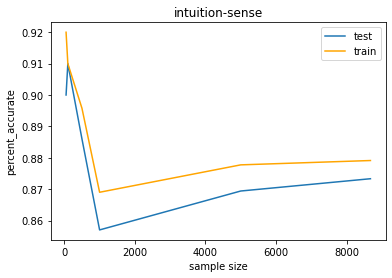

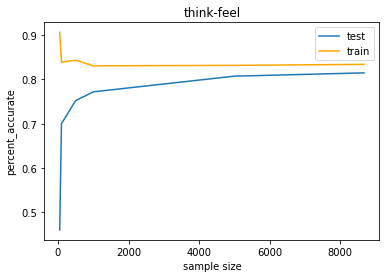

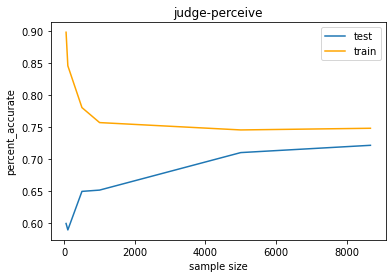

In [11]:
for o in outs:
    cv_mean_r2, cv_mean_r2_train = [], []
    for sz in sizes:
        np.random.seed(0)
        ridx = np.random.randint(0, X.shape[0], sz)
        X_subs = X[ridx, :]
        y_subs = df[o].values[ridx]
        cv_scores = cross_validate(est_log, X_subs, y_subs, 
                                cv=gkfolds, return_train_score=True)
        mean_r2 = cv_scores['test_score'].mean()
        mean_r2_train = cv_scores['train_score'].mean()
        cv_mean_r2.append(mean_r2)
        cv_mean_r2_train.append(mean_r2_train)
    sns.lineplot(sizes, cv_mean_r2, label='test')
    sns.lineplot(sizes, cv_mean_r2_train, color='orange', label='train')
    plt.xlabel('sample size')
    plt.ylabel('percent_accurate')
    plt.title(o)
    plt.show()